# Gestural drawing example (vector version)

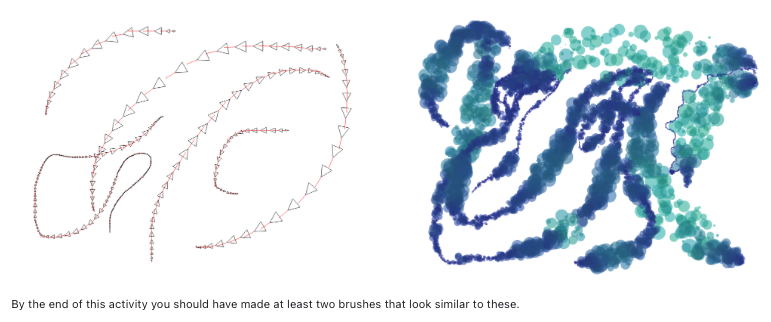

## Instructions:

In this version of the sketch we will use vectors instead of specifying coordinates, which will simplify the code. We will then modify the code to save PDF/SVG files. 

### __1)__  Create the sketch
Create a Python file and insert this code in the sketch:
```Python
from py5canvas import *

def setup():
    create_canvas(512, 512)
    background(0)

def draw():
    background(0)
    circle(mouse_pos, 50)

run()
```
Here we use the vector property ~mouse_pos~ instead of ~mouse_x~ and ~mouse_y~


### __2)__  Implementing painting and not-painting
  
When the user presses the mouse they should be able to draw, when they release the mouse the drawing should stop. 

You can do this by checking the `dragging` property inside an `if` statement to check if the mouse is pressed in every frame (in `draw`), e.g.:
```Python
if dragging:
    my_drawing_code()
```
remember to replace `my_drawing_code()` with `circle(mouse_pos, 10)`. 
Now comment the `background` call inside `draw` and save. If your script is running you will see that now you can draw in the screen.

**Run your program, you should be able to do draw only when you press the mouse now!**

### __3)__ A dynamic brush with simple gestural control
  
A dynamic brush is one that changes as the user is painting with it. A dynamic brush might change colour as you paint, or it might change shape, or both. We are going to create a brush that changes depending on how fast you paint using some simple math

#### Gestural effect
A simple way to get a gestural effect is known as the ["1 Euro Filter"](https://gery.casiez.net/1euro/). While the description linked might seem complicated, this can be easily implemented by defining these variables outside of the functions `setup` and `draw`:
```Python
amt = 0.25
brush_pos = Vector(0, 0)
```
The first variable defines a relative amount by which we move each frame towards the current position of the mouse. The two are used to store the current position of the brush.

In draw, we will write the following:
```Python
# Allow to modify brush_pos
global brush_pos
# Brush displacement vector (x and y)
# It moves the brush position by a small amount in the direction of the mouse
offset = (mouse_pos - brush_pos)*amt
# Update the brush position
brush_pos = brush_pos + offset
```
and use `brush_pos` instead of `mouse_pos` when you draw

#### Globals
Here we encounter an example of where the `global` keyword is useful in a sketch. We define global variables that are accessible for all the lifetime of the sketch, where we can store information as the current position of the brush. As we have seen in the tutorial, we need to declare them as `global` inside draw before modifying them.

#### Changing size 

We can determine a scale depending on the speed of the movement by measuring the length of the offset vector we used to move the brush position. We can do this with
```Python
speed = mag(offset)
```
where `mag` gives us the length of the vector `offset`. 

We then use `remap` to get a scale for the radius of the circle we are drawing:
```Python
scale_factor = remap(d, 0, 50, 0.1, 1.0)
```
This will map slower movement to a a smaller scale factor. We can see the effect if we multiply the circle radius by `scale_factor`.


#### Determining the angle
If you want to rotate an object in the direction of the movement you can get the orientation of the `offset` vector using the `heading` function. 
```C
angle = heading(offset)
``` 
It gives us the angle in [radians](https://en.wikipedia.org/wiki/Radian) (not degrees). 

We now can use transformations to rotate an object along the movement. Put the following inside the `if` statement instead of the circle
```Python
# Draw a line in the direction of movement
stroke(255, 60)
line(brush_pos, brush_pos + offset*8)
# Rotate a triangle based on the orientation of the movement vector
stroke(0)
push()
translate(brush_pos)
rotate(heading(offset))
scale(scale_factor)
triangle(0, -50, 100, 0, 0, 50)
pop()
```
Note that the triangle is drawn so it is initially longer in the X direction, and it is rotated with the previously computed angle

Also try experimenting with other shapes. How could you achieve a pattern similar to the blue one in the image above? Hint: use `random`, `fill` and `no_stroke`.
 
##### __Saving vector drawings__

The current version of this application only can output raster images. The reason for this is that we achieve a drawing effect by not clearing the canvas (with background) and accumulating pixels over it's "surface". Each time `draw` is called we only draw a part a "brush shape" and if we were to try to save a vector file (SVG or PDF) we would end up with only that shape. 

To do so, we need to store some information in lists using `append` and then every frame redraw all the shapes that make a brush trajectory. 
**Let's start with duplicating our previous drawing sketch**, so we keep track of our progress.

Then add the following global variables:
```python
positions = []
offsets = []
```

These are empty lists that will keep track of the brush positions and corresponding offsets (to rotate/scale shapes). Now replace the draw function with 
```python
def draw():
    background(0)

    # Allow to modify brush_pos
    global brush_pos
    # Brush displacement vector (x and y)
    # It moves the brush position by a small amount in the direction of the mouse
    offset = (mouse_pos - brush_pos)*amt
    # Update the brush position
    brush_pos = brush_pos + offset

    if dragging:
        positions.append(brush_pos)
        offsets.append(offset)
```

This does not draw anything yet, but it stores the current `brush_pos` nd the current `offset` in two separate lists if we press the mouse button. If we do only this the lists will grow without an end until our sketch will run extremely slow. To avoid that, we can check if one of the lists reaches a capacity limit we define and remove one element if it does. Now add this, inside `draw` and after the `if dragging` statement. Watch the indentation, this should be *inside* draw:
```python
if len(positions) > 200:
    positions.pop(0)
    offsets.pop(0)
```
This code checks if we have more than 200 items inside the `positions` list and removes one item from the beginning of both `positions` and `offset` if that is the case. This means that our lists grow until they reach full capacity (200 elements, but you can change that) and stay at this maximum capacity from there on. It is important to remove elements from the beginning in this case using `positions.pop(0)`, because otherwise we would remove the element from the end with `positions.pop()` we would remove the last position we added to the list.

Now you can convert your code to draw **all** the positions and offsets we added to the list. One way to do this is with the code from earlier on is putting this at the end of and inside the function `draw` (remember to indent your code so it is inside `draw`)
```python
num_positions = len(positions)
for i in range(num_positions):
    pos = positions[i]
    offset = offsets[i]
    # Get the scale based on speed of mouse movement (distance covered by offset)
    speed = mag(offset)
    # Remap speed to a scale factor
    scale_factor = remap(speed, 0, 50, 0.1, 1.0)
    
    # Draw a line in the direction of movement
    stroke(255, 60)
    line(pos, pos + offset*8)
    # Rotate a triangle based on the orientation of the movement vector
    stroke(0)
    push()
    translate(pos)
    rotate(heading(offset))
    scale(scale_factor)
    triangle(0, -50, 100, 0, 0, 50)
    pop()
```

###### __Saving__
While in a notebook we can simply create a canvas, draw on it and save, with an interactive sketch we need to decide when to save based on some input from the user. We can use the keyboard, say when the space bar is pressed. To do so add the following function to your sketch (before `run`):
```python
def key_pressed(key):
    if key == ' ':
        save('brush.pdf')
```
The `key_pressed` function is automatically called if you press any key on your keyboard, and `key==' '` tests if the key is the space.

Alternatively you can try to replace run with the following.
```python
run(show_toolbar=True)
```
For some of you, this will display some buttons in the window that will allow you to save SVG or PDF files of your sketch.



##### __Ideas for play and experimentation at home:__

* Try drawing different shapes. 
* Try to put your drawing code into a function.
* can you use the magnitude and direction to change styling? For example color, line width etc..
* can you use randomness or noise in other ways so that the user is not fully in control? For examples could you use the spin example from the code examples as a brush, can you change the weight or color of the line as you draw?



##### __Ideas for more advanced coders:__
You can get more complex gestural effects by modeling a damped spring that follows the mouse. 
[This](https://icculus.org/~lucasw/Dynamics/Spring%20Tutorial.html) is an example explanation of how it can be implemented. Spring dynamics can be implemented by storing x and y velocity as variables and using the displacement towards the mouse to determine acceleration and then integrating (summing in time).

Also worth looking at [DynaDraw](http://www.graficaobscura.com/dyna/) by Paul Haeberli. It provides C code for a gestural drawing program that should not be too difficult to port to Python (let me know if you do it!).